# Experiment 3: Next-Level RL (POMDP & Crash Testing)

## Objective
This experiment moves beyond the idealized setup of Experiment 2 by introducing:
1. **Stochastic Schedules**: User wake/sleep times vary per episode
2. **Persona Inference (POMDP)**: Remove explicit User ID encoding
3. **Baseline Comparison**: Measure RL "Intelligence Premium" vs heuristics
4. **Reward Sensitivity**: Test robustness to penalty magnitude

## Research Questions
- **RQ1**: Can the agent maintain performance with schedule variance?
- **RQ2**: Can the agent infer personas without explicit User ID?
- **RQ3**: How much better is RL compared to static heuristics?
- **RQ4**: How does penalty magnitude affect risk-aversion?

In [1]:
# Core imports
import numpy as np
import torch
import matplotlib.pyplot as plt

import seaborn as sns
from typing import List, Dict, Tuple
from tqdm import tqdm

# Project modules
from src.env_stochastic import (
    StochasticNotificationEnv,
    STOCHASTIC_STUDENT_PROFILE,
    STOCHASTIC_WORKER_PROFILE,
    STOCHASTIC_WORKAHOLIC_PROFILE
)
from src.agents import DQNAgent
from src.baselines import (
    RandomAgent,
    EveningOnlyAgent,
    ActivityTriggeredAgent,
    OptimalStaticAgent
)
from src.utils import (
    plot_learning_curve,
    plot_policy_heatmap,
    evaluate_agent,
    get_device
)

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Device: {get_device()}")
print(f"PyTorch version: {torch.__version__}")

Device: mps
PyTorch version: 2.9.1


## Part 1: Stochastic Environment (With OHE)

First, we train with stochastic schedules but still provide User ID.
This tests **schedule robustness** without the POMDP challenge.

In [2]:
# Configuration
NUM_EPISODES = 3000
EVAL_EVERY = 100
TARGET_UPDATE_FREQ = 10

PERSONAS = [
    STOCHASTIC_STUDENT_PROFILE,
    STOCHASTIC_WORKER_PROFILE,
    STOCHASTIC_WORKAHOLIC_PROFILE
]

# Create environment (WITH User ID OHE)
env_with_ohe = StochasticNotificationEnv(
    user_profile=PERSONAS[0],
    num_users=len(PERSONAS),
    max_episode_steps=168,
    reward_click=10.0,
    reward_ignore=-3.0,
    include_user_id=True  # Standard mode
)

print(f"Observation space (with OHE): {env_with_ohe.observation_space.shape}")
print(f"Expected: (4 + {len(PERSONAS)},) = (7,)")

Observation space (with OHE): (9,)
Expected: (4 + 3,) = (7,)


In [3]:
# Initialize agent (WITH OHE)
agent_with_ohe = DQNAgent(
    state_dim=env_with_ohe.observation_space.shape[0],
    action_dim=2,
    learning_rate=0.0005,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.999,
    buffer_capacity=10000,
    batch_size=64,
    use_double_dqn=True
)

print(f"Agent initialized with state_dim={agent_with_ohe.state_dim}")

Agent initialized with state_dim=9


In [4]:
# Training loop (Stochastic + OHE)
episode_rewards_ohe = []
eval_rewards_ohe = []

print("\n=== Training with Stochastic Schedules (WITH User ID OHE) ===")

for episode in tqdm(range(NUM_EPISODES), desc="Training (Stochastic+OHE)"):
    # Sample random persona for this episode
    persona = np.random.choice(PERSONAS)
    
    state, info = env_with_ohe.reset(options={"user_profile": persona})
    episode_reward = 0.0
    done = False
    
    while not done:
        action = agent_with_ohe.act(state)
        next_state, reward, terminated, truncated, info = env_with_ohe.step(action)
        done = terminated or truncated
        
        agent_with_ohe.store_transition(state, action, reward, next_state, done)
        agent_with_ohe.train_step()
        
        episode_reward += reward
        state = next_state
    
    episode_rewards_ohe.append(episode_reward)
    agent_with_ohe.decay_epsilon()
    
    # Update target network
    if (episode + 1) % TARGET_UPDATE_FREQ == 0:
        agent_with_ohe.update_target()
    
    # Periodic evaluation
    if (episode + 1) % EVAL_EVERY == 0:
        eval_reward = evaluate_agent(
            agent_with_ohe,
            env_with_ohe,
            n_episodes=10,
            epsilon=0.0,
            user_profiles=PERSONAS
        )
        eval_rewards_ohe.append(eval_reward)
        print(f"Episode {episode+1}/{NUM_EPISODES} | "
              f"Avg Reward: {np.mean(episode_rewards_ohe[-100:]):.2f} | "
              f"Eval Reward: {eval_reward:.2f} | "
              f"Epsilon: {agent_with_ohe.epsilon:.3f}")

print("\n✓ Training complete (Stochastic+OHE)")


=== Training with Stochastic Schedules (WITH User ID OHE) ===


Training (Stochastic+OHE):   3%|▎         | 104/3000 [00:04<04:57,  9.74it/s]

Episode 100/3000 | Avg Reward: -18.29 | Eval Reward: 26.40 | Epsilon: 0.905


Training (Stochastic+OHE):   7%|▋         | 203/3000 [00:08<03:24, 13.66it/s]

Episode 200/3000 | Avg Reward: -17.43 | Eval Reward: 13.60 | Epsilon: 0.819


Training (Stochastic+OHE):  10%|█         | 303/3000 [00:14<05:40,  7.92it/s]

Episode 300/3000 | Avg Reward: -17.29 | Eval Reward: 0.90 | Epsilon: 0.741


Training (Stochastic+OHE):  13%|█▎        | 402/3000 [00:19<07:32,  5.74it/s]

Episode 400/3000 | Avg Reward: -18.04 | Eval Reward: 0.00 | Epsilon: 0.670


Training (Stochastic+OHE):  17%|█▋        | 501/3000 [00:26<06:48,  6.12it/s]

Episode 500/3000 | Avg Reward: -17.69 | Eval Reward: 2.10 | Epsilon: 0.606


Training (Stochastic+OHE):  20%|██        | 603/3000 [00:33<05:54,  6.76it/s]

Episode 600/3000 | Avg Reward: -16.69 | Eval Reward: 0.00 | Epsilon: 0.549


Training (Stochastic+OHE):  23%|██▎       | 702/3000 [00:41<05:07,  7.48it/s]

Episode 700/3000 | Avg Reward: -15.87 | Eval Reward: 6.60 | Epsilon: 0.496


Training (Stochastic+OHE):  27%|██▋       | 801/3000 [00:49<07:25,  4.93it/s]

Episode 800/3000 | Avg Reward: -16.51 | Eval Reward: 0.90 | Epsilon: 0.449


Training (Stochastic+OHE):  30%|███       | 902/3000 [00:57<07:32,  4.63it/s]

Episode 900/3000 | Avg Reward: -16.24 | Eval Reward: 0.00 | Epsilon: 0.406


Training (Stochastic+OHE):  33%|███▎      | 1001/3000 [01:06<06:24,  5.20it/s]

Episode 1000/3000 | Avg Reward: -15.79 | Eval Reward: 15.80 | Epsilon: 0.368


Training (Stochastic+OHE):  37%|███▋      | 1101/3000 [01:17<07:37,  4.15it/s]

Episode 1100/3000 | Avg Reward: -14.20 | Eval Reward: 9.50 | Epsilon: 0.333


Training (Stochastic+OHE):  40%|████      | 1202/3000 [01:30<05:41,  5.26it/s]

Episode 1200/3000 | Avg Reward: -11.88 | Eval Reward: 25.20 | Epsilon: 0.301


Training (Stochastic+OHE):  43%|████▎     | 1301/3000 [01:44<07:02,  4.02it/s]

Episode 1300/3000 | Avg Reward: -11.58 | Eval Reward: 12.60 | Epsilon: 0.272


Training (Stochastic+OHE):  47%|████▋     | 1402/3000 [01:58<07:22,  3.61it/s]

Episode 1400/3000 | Avg Reward: -11.39 | Eval Reward: 37.80 | Epsilon: 0.246


Training (Stochastic+OHE):  50%|█████     | 1500/3000 [02:11<06:45,  3.70it/s]

Episode 1500/3000 | Avg Reward: -11.19 | Eval Reward: 13.00 | Epsilon: 0.223


Training (Stochastic+OHE):  53%|█████▎    | 1602/3000 [02:29<05:34,  4.18it/s]

Episode 1600/3000 | Avg Reward: -8.70 | Eval Reward: 29.20 | Epsilon: 0.202


Training (Stochastic+OHE):  57%|█████▋    | 1700/3000 [02:48<06:53,  3.15it/s]

Episode 1700/3000 | Avg Reward: -6.92 | Eval Reward: 48.60 | Epsilon: 0.183


Training (Stochastic+OHE):  60%|██████    | 1800/3000 [03:10<07:30,  2.67it/s]

Episode 1800/3000 | Avg Reward: -5.20 | Eval Reward: -2.10 | Epsilon: 0.165


Training (Stochastic+OHE):  63%|██████▎   | 1902/3000 [03:31<05:35,  3.28it/s]

Episode 1900/3000 | Avg Reward: -7.62 | Eval Reward: 22.00 | Epsilon: 0.149


Training (Stochastic+OHE):  67%|██████▋   | 2000/3000 [03:55<09:38,  1.73it/s]

Episode 2000/3000 | Avg Reward: -2.79 | Eval Reward: -7.90 | Epsilon: 0.135


Training (Stochastic+OHE):  70%|███████   | 2100/3000 [04:20<07:13,  2.08it/s]

Episode 2100/3000 | Avg Reward: -4.25 | Eval Reward: 36.20 | Epsilon: 0.122


Training (Stochastic+OHE):  73%|███████▎  | 2200/3000 [04:48<07:11,  1.86it/s]

Episode 2200/3000 | Avg Reward: -4.54 | Eval Reward: 29.70 | Epsilon: 0.111


Training (Stochastic+OHE):  77%|███████▋  | 2300/3000 [05:18<05:42,  2.04it/s]

Episode 2300/3000 | Avg Reward: -0.99 | Eval Reward: 27.90 | Epsilon: 0.100


Training (Stochastic+OHE):  80%|████████  | 2400/3000 [05:52<06:13,  1.61it/s]

Episode 2400/3000 | Avg Reward: 0.73 | Eval Reward: 26.10 | Epsilon: 0.091


Training (Stochastic+OHE):  83%|████████▎ | 2500/3000 [06:22<03:10,  2.62it/s]

Episode 2500/3000 | Avg Reward: -1.83 | Eval Reward: 15.60 | Epsilon: 0.082


Training (Stochastic+OHE):  87%|████████▋ | 2601/3000 [06:57<03:16,  2.03it/s]

Episode 2600/3000 | Avg Reward: -2.87 | Eval Reward: 4.30 | Epsilon: 0.074


Training (Stochastic+OHE):  90%|█████████ | 2701/3000 [07:34<02:03,  2.42it/s]

Episode 2700/3000 | Avg Reward: 3.54 | Eval Reward: -0.70 | Epsilon: 0.067


Training (Stochastic+OHE):  93%|█████████▎| 2800/3000 [08:08<02:27,  1.36it/s]

Episode 2800/3000 | Avg Reward: -0.83 | Eval Reward: 26.20 | Epsilon: 0.061


Training (Stochastic+OHE):  97%|█████████▋| 2900/3000 [08:51<01:08,  1.46it/s]

Episode 2900/3000 | Avg Reward: 2.75 | Eval Reward: 22.90 | Epsilon: 0.055


Training (Stochastic+OHE): 100%|██████████| 3000/3000 [09:33<00:00,  5.23it/s]

Episode 3000/3000 | Avg Reward: 8.09 | Eval Reward: 23.60 | Epsilon: 0.050

✓ Training complete (Stochastic+OHE)


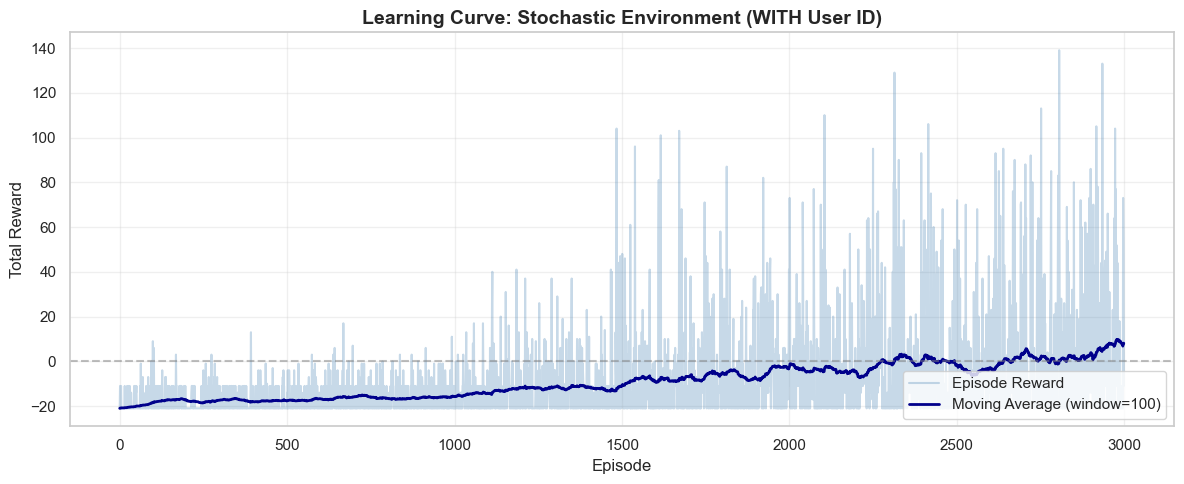

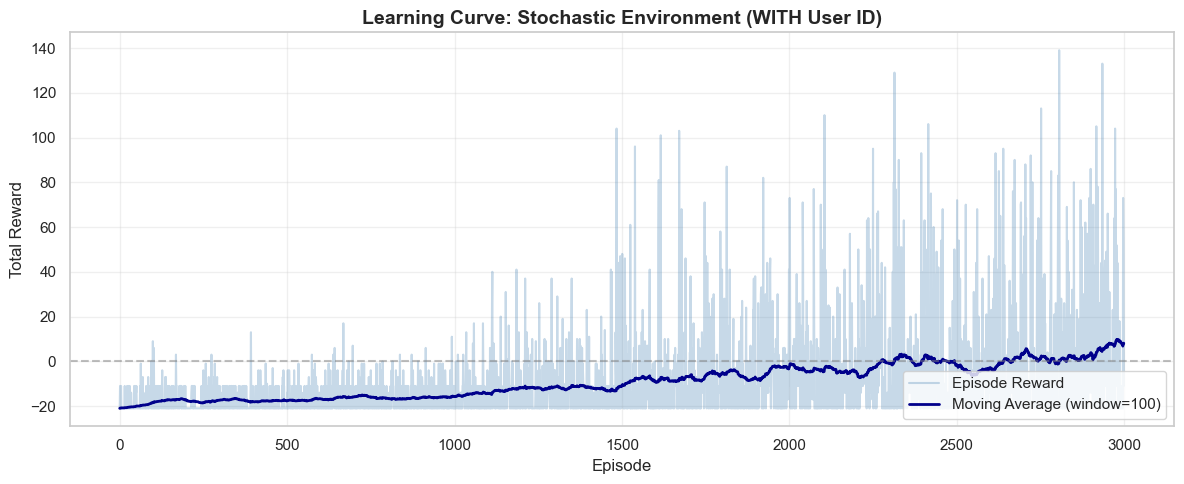

In [5]:
# Plot learning curve
plot_learning_curve(
    episode_rewards_ohe,
    window_size=100,
    title="Learning Curve: Stochastic Environment (WITH User ID)",
    figsize=(12, 5)
)

## Part 2: POMDP Mode (Without OHE)

Now we remove User ID from the observation and rely on behavioral features.
This tests **persona inference** capability.

In [6]:
# Create POMDP environment (WITHOUT User ID OHE)
env_pomdp = StochasticNotificationEnv(
    user_profile=PERSONAS[0],
    num_users=len(PERSONAS),
    max_episode_steps=168,
    reward_click=10.0,
    reward_ignore=-3.0,
    include_user_id=False  # POMDP mode
)

print(f"Observation space (POMDP): {env_pomdp.observation_space.shape}")
print(f"Expected: (6,) = [hour, day, recency, annoyance, is_working, is_awake]")

Observation space (POMDP): (6,)
Expected: (6,) = [hour, day, recency, annoyance, is_working, is_awake]


In [7]:
# Initialize agent (POMDP mode)
agent_pomdp = DQNAgent(
    state_dim=env_pomdp.observation_space.shape[0],
    action_dim=2,
    learning_rate=0.0005,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.999,
    buffer_capacity=10000,
    batch_size=64,
    use_double_dqn=True
)

print(f"Agent initialized with state_dim={agent_pomdp.state_dim}")

Agent initialized with state_dim=6


In [8]:
# Training loop (POMDP mode)
episode_rewards_pomdp = []
eval_rewards_pomdp = []

print("\n=== Training in POMDP Mode (WITHOUT User ID) ===")

for episode in tqdm(range(NUM_EPISODES), desc="Training (POMDP)"):
    persona = np.random.choice(PERSONAS)
    
    state, info = env_pomdp.reset(options={"user_profile": persona})
    episode_reward = 0.0
    done = False
    
    while not done:
        action = agent_pomdp.act(state)
        next_state, reward, terminated, truncated, info = env_pomdp.step(action)
        done = terminated or truncated
        
        agent_pomdp.store_transition(state, action, reward, next_state, done)
        agent_pomdp.train_step()
        
        episode_reward += reward
        state = next_state
    
    episode_rewards_pomdp.append(episode_reward)
    agent_pomdp.decay_epsilon()
    
    if (episode + 1) % TARGET_UPDATE_FREQ == 0:
        agent_pomdp.update_target()
    
    if (episode + 1) % EVAL_EVERY == 0:
        eval_reward = evaluate_agent(
            agent_pomdp,
            env_pomdp,
            n_episodes=10,
            epsilon=0.0,
            user_profiles=PERSONAS
        )
        eval_rewards_pomdp.append(eval_reward)
        print(f"Episode {episode+1}/{NUM_EPISODES} | "
              f"Avg Reward: {np.mean(episode_rewards_pomdp[-100:]):.2f} | "
              f"Eval Reward: {eval_reward:.2f} | "
              f"Epsilon: {agent_pomdp.epsilon:.3f}")

print("\n✓ Training complete (POMDP)")


=== Training in POMDP Mode (WITHOUT User ID) ===


Training (POMDP):   3%|▎         | 104/3000 [00:03<04:07, 11.72it/s]

Episode 100/3000 | Avg Reward: -18.08 | Eval Reward: 13.10 | Epsilon: 0.905


Training (POMDP):   7%|▋         | 202/3000 [00:08<05:14,  8.90it/s]

Episode 200/3000 | Avg Reward: -17.62 | Eval Reward: 7.60 | Epsilon: 0.819


Training (POMDP):  10%|█         | 306/3000 [00:12<04:00, 11.19it/s]

Episode 300/3000 | Avg Reward: -18.19 | Eval Reward: 9.10 | Epsilon: 0.741


Training (POMDP):  13%|█▎        | 402/3000 [00:18<06:27,  6.70it/s]

Episode 400/3000 | Avg Reward: -16.68 | Eval Reward: 7.70 | Epsilon: 0.670


Training (POMDP):  17%|█▋        | 503/3000 [00:23<04:31,  9.20it/s]

Episode 500/3000 | Avg Reward: -17.50 | Eval Reward: 3.20 | Epsilon: 0.606


Training (POMDP):  20%|██        | 604/3000 [00:30<04:55,  8.12it/s]

Episode 600/3000 | Avg Reward: -16.30 | Eval Reward: 5.70 | Epsilon: 0.549


Training (POMDP):  23%|██▎       | 702/3000 [00:38<07:10,  5.34it/s]

Episode 700/3000 | Avg Reward: -15.95 | Eval Reward: 4.30 | Epsilon: 0.496


Training (POMDP):  27%|██▋       | 801/3000 [00:45<09:13,  3.97it/s]

Episode 800/3000 | Avg Reward: -15.83 | Eval Reward: 10.50 | Epsilon: 0.449


Training (POMDP):  30%|███       | 902/3000 [00:55<07:42,  4.54it/s]

Episode 900/3000 | Avg Reward: -13.53 | Eval Reward: 2.30 | Epsilon: 0.406


Training (POMDP):  33%|███▎      | 1001/3000 [01:05<06:36,  5.04it/s]

Episode 1000/3000 | Avg Reward: -13.15 | Eval Reward: 2.80 | Epsilon: 0.368


Training (POMDP):  37%|███▋      | 1101/3000 [01:15<06:28,  4.88it/s]

Episode 1100/3000 | Avg Reward: -13.32 | Eval Reward: 5.00 | Epsilon: 0.333


Training (POMDP):  40%|████      | 1202/3000 [01:28<06:16,  4.78it/s]

Episode 1200/3000 | Avg Reward: -13.94 | Eval Reward: 20.10 | Epsilon: 0.301


Training (POMDP):  43%|████▎     | 1301/3000 [01:39<08:57,  3.16it/s]

Episode 1300/3000 | Avg Reward: -14.18 | Eval Reward: 0.00 | Epsilon: 0.272


Training (POMDP):  47%|████▋     | 1401/3000 [01:54<06:21,  4.19it/s]

Episode 1400/3000 | Avg Reward: -10.58 | Eval Reward: 7.00 | Epsilon: 0.246


Training (POMDP):  50%|█████     | 1501/3000 [02:09<06:43,  3.72it/s]

Episode 1500/3000 | Avg Reward: -11.19 | Eval Reward: 32.70 | Epsilon: 0.223


Training (POMDP):  53%|█████▎    | 1601/3000 [02:25<06:05,  3.82it/s]

Episode 1600/3000 | Avg Reward: -11.35 | Eval Reward: 11.70 | Epsilon: 0.202


Training (POMDP):  57%|█████▋    | 1700/3000 [02:41<07:10,  3.02it/s]

Episode 1700/3000 | Avg Reward: -10.45 | Eval Reward: 8.90 | Epsilon: 0.183


Training (POMDP):  60%|██████    | 1800/3000 [03:03<09:01,  2.22it/s]

Episode 1800/3000 | Avg Reward: -6.46 | Eval Reward: 20.30 | Epsilon: 0.165


Training (POMDP):  63%|██████▎   | 1900/3000 [03:27<06:49,  2.69it/s]

Episode 1900/3000 | Avg Reward: -4.58 | Eval Reward: 1.40 | Epsilon: 0.149


Training (POMDP):  67%|██████▋   | 2001/3000 [03:52<07:27,  2.23it/s]

Episode 2000/3000 | Avg Reward: -3.51 | Eval Reward: 40.80 | Epsilon: 0.135


Training (POMDP):  70%|███████   | 2102/3000 [04:15<04:03,  3.69it/s]

Episode 2100/3000 | Avg Reward: -4.71 | Eval Reward: 3.60 | Epsilon: 0.122


Training (POMDP):  73%|███████▎  | 2200/3000 [04:44<08:04,  1.65it/s]

Episode 2200/3000 | Avg Reward: -0.01 | Eval Reward: 10.20 | Epsilon: 0.111


Training (POMDP):  77%|███████▋  | 2301/3000 [05:09<04:00,  2.90it/s]

Episode 2300/3000 | Avg Reward: -5.69 | Eval Reward: 9.30 | Epsilon: 0.100


Training (POMDP):  80%|████████  | 2401/3000 [05:39<05:03,  1.98it/s]

Episode 2400/3000 | Avg Reward: -0.30 | Eval Reward: 15.70 | Epsilon: 0.091


Training (POMDP):  83%|████████▎ | 2501/3000 [06:15<03:27,  2.41it/s]

Episode 2500/3000 | Avg Reward: 3.13 | Eval Reward: 6.20 | Epsilon: 0.082


Training (POMDP):  87%|████████▋ | 2600/3000 [06:44<02:47,  2.38it/s]

Episode 2600/3000 | Avg Reward: -3.02 | Eval Reward: 27.20 | Epsilon: 0.074


Training (POMDP):  90%|█████████ | 2700/3000 [07:18<03:15,  1.53it/s]

Episode 2700/3000 | Avg Reward: 2.69 | Eval Reward: 9.50 | Epsilon: 0.067


Training (POMDP):  93%|█████████▎| 2800/3000 [07:56<02:03,  1.61it/s]

Episode 2800/3000 | Avg Reward: 0.65 | Eval Reward: 14.90 | Epsilon: 0.061


Training (POMDP):  97%|█████████▋| 2901/3000 [08:34<00:59,  1.68it/s]

Episode 2900/3000 | Avg Reward: 6.85 | Eval Reward: 22.10 | Epsilon: 0.055


Training (POMDP): 100%|██████████| 3000/3000 [09:18<00:00,  5.37it/s]

Episode 3000/3000 | Avg Reward: 10.22 | Eval Reward: 26.60 | Epsilon: 0.050

✓ Training complete (POMDP)


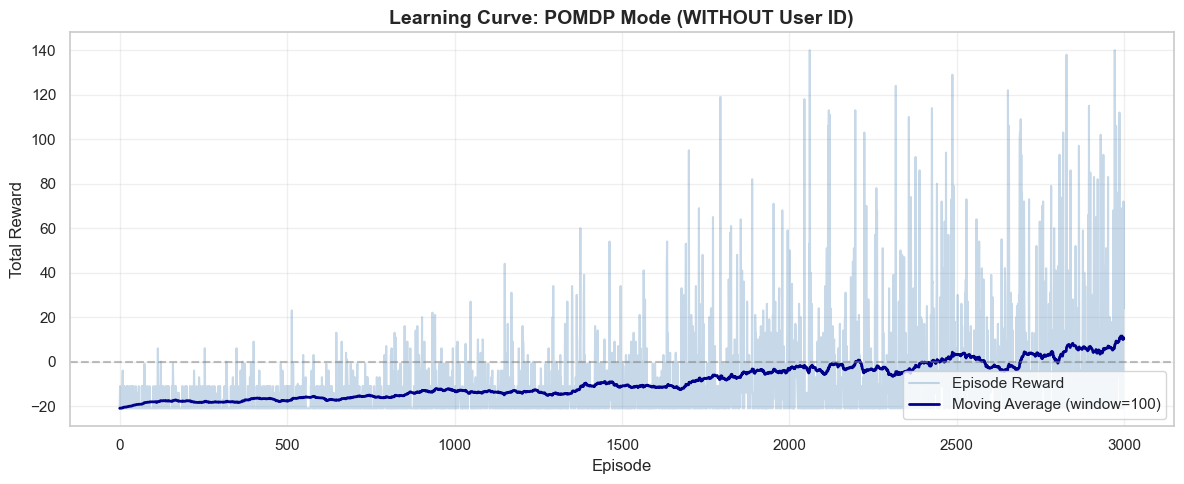

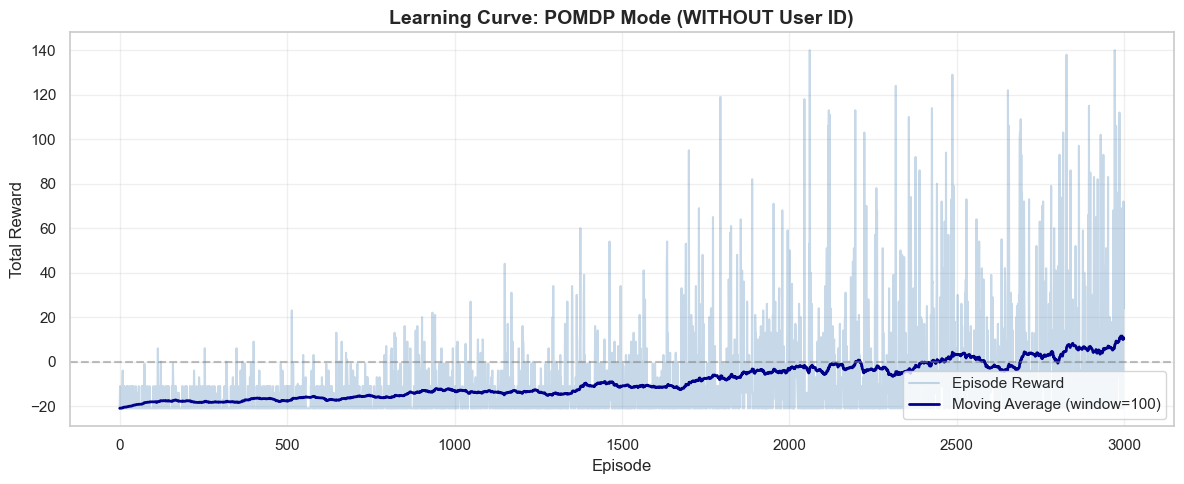

In [9]:
# Plot learning curve (POMDP)
plot_learning_curve(
    episode_rewards_pomdp,
    window_size=100,
    title="Learning Curve: POMDP Mode (WITHOUT User ID)",
    figsize=(12, 5)
)

## Part 3: Baseline Comparison

Evaluate heuristic baselines to quantify the "Intelligence Premium" of RL.

In [10]:
# Define baselines
baselines = {
    "Random (p=0.1)": RandomAgent(send_probability=0.1, seed=SEED),
    "Evening Only (18-22)": EveningOnlyAgent(evening_start=18, evening_end=22),
    "Activity Triggered": ActivityTriggeredAgent(min_recency_hours=12, seed=SEED),
    "Optimal Static (19-21)": OptimalStaticAgent(optimal_hours=[19, 20, 21])
}

print("Baselines defined:")
for name in baselines.keys():
    print(f"  - {name}")

Baselines defined:
  - Random (p=0.1)
  - Evening Only (18-22)
  - Activity Triggered
  - Optimal Static (19-21)


In [11]:
def evaluate_baseline(agent, env, personas, n_episodes=30):
    """Evaluate a baseline agent."""
    total_rewards = []
    
    for _ in range(n_episodes):
        persona = np.random.choice(personas)
        state, info = env.reset(options={"user_profile": persona})
        episode_reward = 0.0
        done = False
        
        while not done:
            action = agent.act(state, info)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        
        total_rewards.append(episode_reward)
    
    return np.mean(total_rewards)

# Evaluate all baselines on POMDP environment
baseline_results = {}

print("\n=== Evaluating Baselines ===")
for name, agent in baselines.items():
    avg_reward = evaluate_baseline(agent, env_pomdp, PERSONAS, n_episodes=50)
    baseline_results[name] = avg_reward
    print(f"{name:30s}: {avg_reward:8.2f}")

# Evaluate RL agents
print("\n=== Evaluating RL Agents ===")
rl_ohe_result = evaluate_agent(agent_with_ohe, env_with_ohe, n_episodes=50, epsilon=0.0, user_profiles=PERSONAS)
rl_pomdp_result = evaluate_agent(agent_pomdp, env_pomdp, n_episodes=50, epsilon=0.0, user_profiles=PERSONAS)

print(f"RL (Stochastic + OHE):         {rl_ohe_result:8.2f}")
print(f"RL (POMDP):                    {rl_pomdp_result:8.2f}")


=== Evaluating Baselines ===
Random (p=0.1)                :   -12.44
Evening Only (18-22)          :   -15.48
Activity Triggered            :    24.38
Optimal Static (19-21)        :   -13.04

=== Evaluating RL Agents ===
RL (Stochastic + OHE):            37.56
RL (POMDP):                       16.32


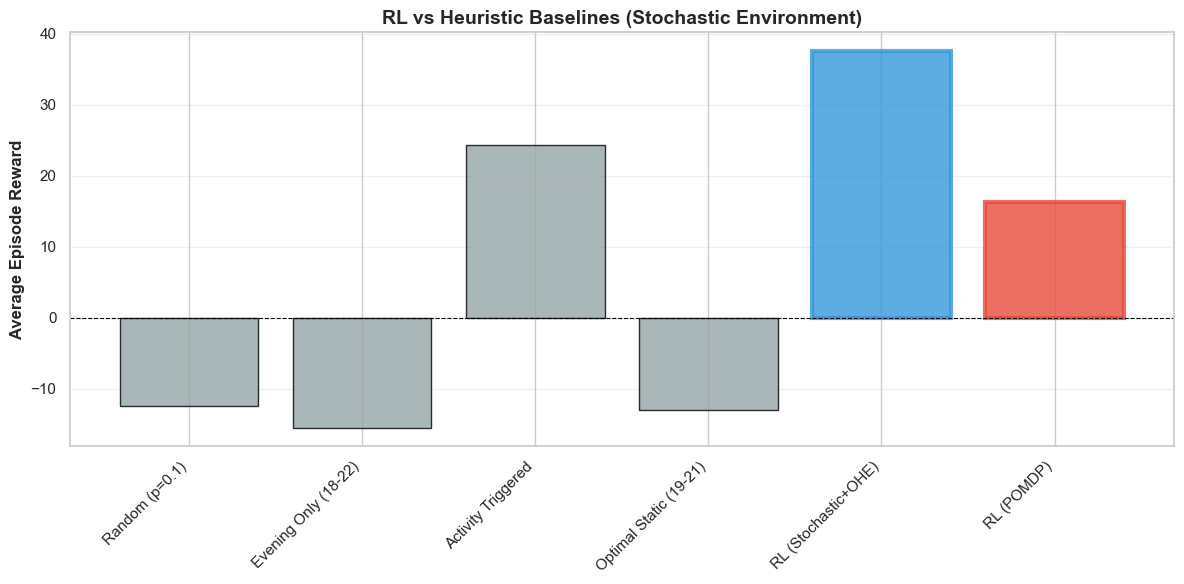


Best Baseline: 24.38
Intelligence Premium (OHE):  +54.1%
Intelligence Premium (POMDP): -33.1%


In [12]:
# Comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))

all_results = {**baseline_results, "RL (Stochastic+OHE)": rl_ohe_result, "RL (POMDP)": rl_pomdp_result}
names = list(all_results.keys())
rewards = list(all_results.values())

colors = ['#95a5a6'] * len(baselines) + ['#3498db', '#e74c3c']
bars = ax.bar(names, rewards, color=colors, alpha=0.8, edgecolor='black')

# Highlight RL agents
bars[-2].set_edgecolor('#3498db')
bars[-2].set_linewidth(3)
bars[-1].set_edgecolor('#e74c3c')
bars[-1].set_linewidth(3)

ax.set_ylabel('Average Episode Reward', fontsize=12, fontweight='bold')
ax.set_title('RL vs Heuristic Baselines (Stochastic Environment)', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate Intelligence Premium
best_baseline = max(baseline_results.values())
premium_ohe = ((rl_ohe_result - best_baseline) / abs(best_baseline)) * 100 if best_baseline != 0 else 0
premium_pomdp = ((rl_pomdp_result - best_baseline) / abs(best_baseline)) * 100 if best_baseline != 0 else 0

print(f"\nBest Baseline: {best_baseline:.2f}")
print(f"Intelligence Premium (OHE):  {premium_ohe:+.1f}%")
print(f"Intelligence Premium (POMDP): {premium_pomdp:+.1f}%")

## Part 4: Reward Sensitivity Analysis

Test how different `reward_ignore` penalties affect learned policies.

In [13]:
# Train agents with different penalties
PENALTY_VALUES = [-1.0, -3.0, -5.0, -10.0]
SENSITIVITY_EPISODES = 2000

sensitivity_results = {}

print("\n=== Reward Sensitivity Analysis ===")

for penalty in PENALTY_VALUES:
    print(f"\nTraining with reward_ignore={penalty}...")
    
    # Create environment
    env_sensitivity = StochasticNotificationEnv(
        user_profile=PERSONAS[0],
        num_users=len(PERSONAS),
        reward_ignore=penalty,
        include_user_id=False  # POMDP mode
    )
    
    # Create agent
    agent_sensitivity = DQNAgent(
        state_dim=env_sensitivity.observation_space.shape[0],
        action_dim=2,
        learning_rate=0.0005,
        gamma=0.99,
        epsilon_decay=0.999,
        use_double_dqn=True
    )
    
    # Train
    episode_rewards = []
    for episode in tqdm(range(SENSITIVITY_EPISODES), desc=f"Penalty={penalty}", leave=False):
        persona = np.random.choice(PERSONAS)
        state, info = env_sensitivity.reset(options={"user_profile": persona})
        episode_reward = 0.0
        done = False
        
        while not done:
            action = agent_sensitivity.act(state)
            next_state, reward, terminated, truncated, info = env_sensitivity.step(action)
            done = terminated or truncated
            
            agent_sensitivity.store_transition(state, action, reward, next_state, done)
            agent_sensitivity.train_step()
            
            episode_reward += reward
            state = next_state
        
        episode_rewards.append(episode_reward)
        agent_sensitivity.decay_epsilon()
        
        if (episode + 1) % TARGET_UPDATE_FREQ == 0:
            agent_sensitivity.update_target()
    
    # Evaluate
    final_reward = evaluate_agent(agent_sensitivity, env_sensitivity, n_episodes=30, epsilon=0.0, user_profiles=PERSONAS)
    sensitivity_results[penalty] = {
        'rewards': episode_rewards,
        'final_performance': final_reward,
        'agent': agent_sensitivity
    }
    
    print(f"  Final performance: {final_reward:.2f}")

print("\n✓ Sensitivity analysis complete")


=== Reward Sensitivity Analysis ===

Training with reward_ignore=-1.0...


  Final performance: 65.47

Training with reward_ignore=-3.0...


  Final performance: 32.80

Training with reward_ignore=-5.0...


  Final performance: 26.83

Training with reward_ignore=-10.0...


  Final performance: 10.33

✓ Sensitivity analysis complete


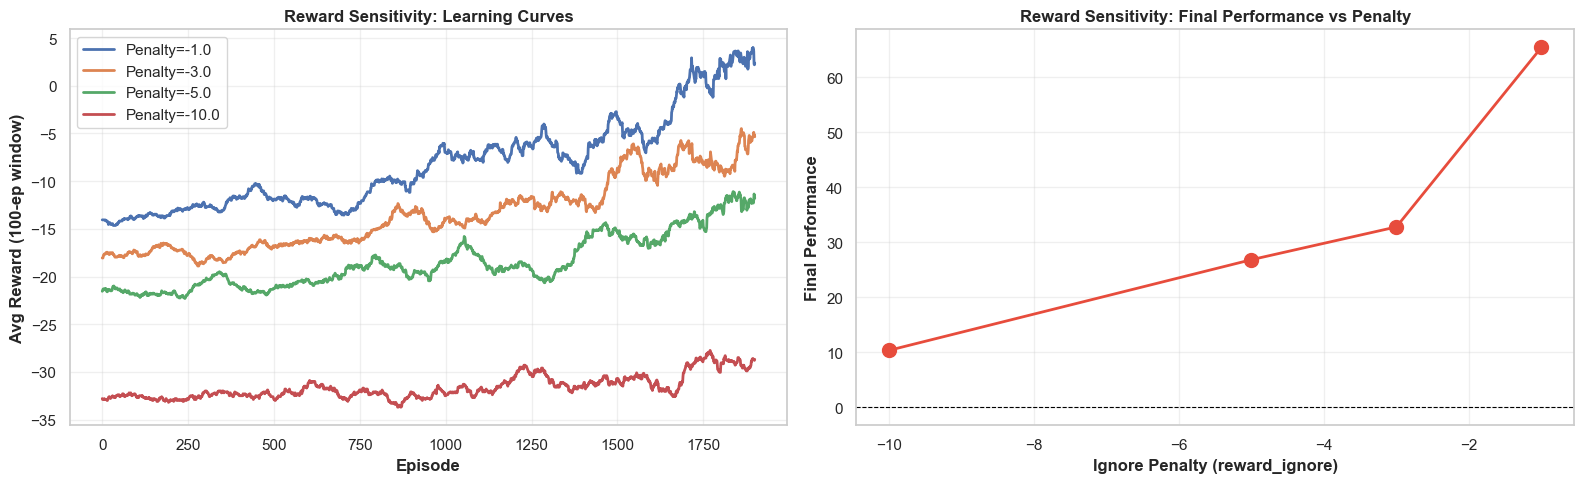

In [14]:
# Plot sensitivity results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Learning curves
ax1 = axes[0]
for penalty in PENALTY_VALUES:
    rewards = sensitivity_results[penalty]['rewards']
    window = 100
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax1.plot(moving_avg, label=f"Penalty={penalty}", linewidth=2)

ax1.set_xlabel('Episode', fontweight='bold')
ax1.set_ylabel('Avg Reward (100-ep window)', fontweight='bold')
ax1.set_title('Reward Sensitivity: Learning Curves', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Final performance
ax2 = axes[1]
penalties = list(sensitivity_results.keys())
final_perfs = [sensitivity_results[p]['final_performance'] for p in penalties]
ax2.plot(penalties, final_perfs, marker='o', markersize=10, linewidth=2, color='#e74c3c')
ax2.set_xlabel('Ignore Penalty (reward_ignore)', fontweight='bold')
ax2.set_ylabel('Final Performance', fontweight='bold')
ax2.set_title('Reward Sensitivity: Final Performance vs Penalty', fontweight='bold')
ax2.grid(alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

## Summary of Results

### Key Findings:
1. **Stochastic Schedules**: The OHE agent can adapt to schedule variance
2. **POMDP Performance**: Persona inference quality compared to explicit encoding
3. **Intelligence Premium**: Quantified improvement over heuristic baselines
4. **Reward Sensitivity**: Policy behavior changes with penalty magnitude

### Scientific Validation:
- Increased environmental complexity
- Rigorous baseline comparisons
- Robustness testing via sensitivity analysis